First things first, you will need a Google account for this tutorial so that you can mount your Google Drive to this Colab notebook. 

If you do not have one then now is a good time to get one. Once you have created it return here and run the following cell. 
- It will prompt you to login and authorize mounting Google Drive. 
- Select the account to link the drive and follow the prompts.

At this point you should also navigate to platform.seclea.com and log in with your credentials. Raise any issues now.

In [ ]:
project_name = "insurance_fraud"

# Google Colab
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    import os
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/seclea/kaggle"
    # /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
    # changing the working directory
    !mkdir /content/gdrive/MyDrive/seclea/
    !mkdir "/content/gdrive/MyDrive/seclea/{project_name}"
    %cd "/content/gdrive/MyDrive/seclea/{project_name}"
    print("Running on Colab, mounted drive and set kaggle path.")
except Exception:
    # not on Colab, do nothing.
    print("Running locally")
    pass

Mounted at /content/gdrive
/content/gdrive/MyDrive/seclea/insurance_fraud
Running on Colab, mounted drive and set kaggle path.


##1. Overview of the Tutorial


This tutorial is designed to familiarise you with using the Seclea AI platform. 

In this tutorial, we will be using a dataset of auto insurance claims as insurance fraud is a huge problem in the industry. It's time consuming and can be complicated to identify and separate fraudulent claims from legitimate ones making it a good candidate for applying ML techniques. When working on this dataset we will be using the following techniques:


1. Data processing techniques 
2. Data balancing techniques 
3. Models to predict if an insurance claim is fraudulent or not. 

We have created two datasets using two different techniques of dealing with Nan values then we treat each dataset with balancing techniques and leave the other without using balancing techniques. Then we train three different models on each dataset. 

# 2. Download the data


In [ ]:
!ls

The data needs to be downloaded using Kaggle. In order to download you will first need to set up access to kaggle.

- Once you have logged in to your account, click on your profile (goose icon) in the top right corner.
- Select Your Profile
- Select the Account tab in that page
- Scroll down to the API section and click the Create New API Token button. A file named kaggle.json will be downloaded.
- Move that file to your Google Drive in the following location
  - The seclea folder inside another folder called kaggle. If it does not already exist then create it.
  - The full path should be MyDrive/seclea/kaggle/kaggle.json

After placing the file run the following cells to download the dataset we will be working with.

In [ ]:
!pip install kaggle
!pip install --upgrade seclea-ai

     |████████████████████████████████| 216 kB 6.2 MB/s 
     |████████████████████████████████| 138 kB 45.4 MB/s 
     |████████████████████████████████| 2.9 MB 32.2 MB/s 
     |████████████████████████████████| 127 kB 44.5 MB/s 
  Created wheel for pickleDB: filename=pickleDB-0.9.2-py3-none-any.whl size=4268 sha256=29ad7f5dda708cb8a2c22bdecbb45a9b689c5b77c6d38b36f5ff72553c80af03
  Stored in directory: /root/.cache/pip/wheels/08/34/42/9a7f94099208ce3d32638d98586a5a50f821db2fc75a3bdaae
Successfully built pickleDB
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!kaggle datasets download -d buntyshah/auto-insurance-claims-data

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 4.31MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  auto-insurance-claims-data.zip
  inflating: insurance_claims.csv    


#3. Load Auto Insurance Dataset




Now we need to load the data into Pandas so that we can start analysing and preparing it for modelling. 

At this time we also need to upload the data in its initial state to the Seclea Platform. This should include whatever information we know about the dataset at this point as metadata.

- You need to fill in the "continuous_features" section of the metadata using the information available in kaggle. Find the dataset information here www.kaggle.com/buntyshah/auto-insurance-claims-data

Here you will also have to log in to the Platform using the credentials given to you.

In [ ]:
#Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from seclea_ai import SecleaAI

# load the data 
df=pd.read_csv('insurance_claims.csv')

# upload the data in its initial state to the Seclea Platform
seclea = SecleaAI(project_name="Tutorial Auto Insurance Fraud (Bruno Yun-2)", organization='University of Aberdeen')

dataset_metadata = {"index": None, 
                    "outcome_name": "fraud_reported", 
                    "continuous_features": [
                                            "total_claim_amount", "policy_annual_premium", "capital-gains", "capital-loss",
                                            "injury_claim", "property_claim", "vehicle_claim", "incident_hour_of_the_day" 
                                            ]}

seclea.upload_dataset(dataset=df, dataset_name="Auto Insurance Fraud", metadata=dataset_metadata)

success
Query Params:  {'project': 6, 'organization': 'University of Aberdeen', 'name': 'Auto Insurance Fraud', 'metadata': '{"index": null, "outcome_name": "fraud_reported", "continuous_features": ["total_claim_amount", "policy_annual_premium", "capital-gains", "capital-loss", "injury_claim", "property_claim", "vehicle_claim", "incident_hour_of_the_day"]}', 'hash': '1686480620896445611', 'parent': None}


In [ ]:
# Check first 5 rows 
df.head(5)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [ ]:
#Check and correct data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

The describe() function in pandas is very handy in getting various summary statistics. This function returns the count, mean, standard deviation, minimum and maximum values, and the quantiles of the data.

In [ ]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,_c39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN


**IMPORTANT - Don't skip this step!!**

\\

Here we use the .copy(deep=True) function to create a new copy of the data from the original one. 

This is to make sure that whatever changes that I make in the copy will not be reflected in my original dataset, in general it is good practice to have every function that modifies the dataset return a new version so that if you want to you can assign it to a new variable and separate the newly modified data from the previous version.
This can often save time in experimentation later. It is also important for managing your development with the Seclea Platform.

There are situations where this is not a good idea such as when working with very large datasets - in this case it is a good idea to save snapshots of the data to disk (or other persistent storage) whenever possible within resource constraints.

In [ ]:
# Creating new copy - to isolate the original dataset
df1 = df.copy(deep=True)

## 3.1 Null values

While examining the dataset with the pandas function for finding nulls, you can see there is only one column with missing values - _c39. But while looking at the dataset closely we can see, there are multiple rows that are filled with  '?'. We need to be careful as '?' is considered an object so it doesn't show up as a null value. 

This reinforces how important it is to study the dataset thoroughly before starting any data processing. 


In [ ]:
#Checking for the missing values 
df1.isnull().sum()

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

## 3.2 Functions
You may notice in this notebook that all our processing of the dataset is within functions. This is for 2 important reasons.

1. Reusability - when working in industry it is a waste of time to keep rewriting the same code for analysing and processing data, particularly if it is done various times with some configuration. By using functions and variables we can reuse the function in another project or even further down in the same project without having to rewrite the logic saving us valuable time.

2. To integrate well with the Seclea Platform. In order to record and use the processing code effectively we need it to be packaged into functions.

A final note, if you are using any thing other than pandas in the function you will need to import it within the function at the start.

In [ ]:
def encode_nans(df):
    """
    Convert the special characters to nans so we can use nan processing code, 
    available in pandas.
    """
    return df.replace('?', np.NaN)

In [ ]:
df1 = encode_nans(df1)

In [ ]:
df1.isnull().sum()

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                  178
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

Now we can see how many null values we actually have and in which columns. We can see there are three more columns containing these values which are collision_type, property_damage , police_report_available as well as  _c39 which we could already see.

## 3.3 Indexing

Depending on our data we may want to define an index for the dataframe. This should be a unique identifier. If there is no reasonable column to consider the index then we can use the default indexing by pandas. In the case of auto insurance dataset we consider policy_number as an index.

In [ ]:
# change Data to  Index 
df1 = df1.set_index('policy_number')

## 3.4 Seclea Platform

Now return to platform.seclea.com.

- You should see a dashboard - select the project from the list of projects at the bottom. You can also select Development in the sidebar and select the project from there.

- Navigate to the Datasets section - under Prepare tab. 

- See the preview and run a PII check to ensure there is no Personally Identifiable Information in the dataset.
 - This is a very important step for many real world datasets.

- Run a format check on the dataset. 
  - This is common practice to ensure that all the data conforms to the expected format which helps ensure consistency during processing.

# 4. Data preprocessing/Feature Engineering 

## 4.1 Dealing with Missing values

We may think that None (or NaN) values are just zeroes because they represent the absence of a value. The main difference between zero and None value is that zero is a value (for example integer or float), while the None value represents the absence of that value.

There are various techniques to replace missing value such as 
1. Fill NaN with Mean, Median or Mode of the data
2. Fill NaN with a constant value
3. Imputing with KNN
4. Imputing with MICE(Multiple Imputation by Chained Equations)

We will try two of these techniques, the constant fill for which we will use the value -1 as the fill value. We will also use the mode filling technique for a second version of the dataset.

Here we define a function to carry out the dropping of columns that contain more than a certain proportion of nulls. We do this as these columns usually don't add useful information and only slow us down.

In [ ]:
def drop_nulls(df, threshold):
    """Drop the the column with certain proportion NaN value."""
    cols = [x for x in df.columns if df[x].isnull().sum() / df.shape[0] > threshold]
    return df.drop(columns=cols)

You will notice that we define the threshold value as a variable and pass it in. That is because we will be using this variable again later to upload these transformations. It is easier than copy and pasting the value.

In [ ]:
# We choose 95% as our threshold
null_thresh = 0.95
df1 = drop_nulls(df1, threshold=null_thresh)

We can see that in this case only _c39 will be dropped as it is 100% null values.


Here you will define the function that will replace nans with a constant value. We have given you the function name and signature, you just have to fill in the rest.



In [ ]:
# Changing 1st dataset with -1 

def fill_nan_const(df, val):
    """Fill NaN values in the dataframe with a constant value"""
    return df.replace( [np.NaN, 'None'], val)

In [ ]:
const_val = -1
df_const = fill_nan_const(df1, const_val)

In [ ]:
df_const.isnull().sum()

months_as_customer             0
age                            0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_report_available        0
total_clai

Here you will also define the function for filling in nans with the mode of the column. Again we have given you the function signature.

One thing to be careful of here is to make sure not to modify the dataframe that is passed into the function. Make a copy if necessary.

In [ ]:
def fill_nan_mode(df, columns):
    

In [ ]:
nan_cols = ['collision_type','property_damage','police_report_available']
df_mode = fill_nan_mode(df1, nan_cols)

In [ ]:
print(df_mode)

               months_as_customer  age  ... auto_year fraud_reported
policy_number                           ...                         
521585                        328   48  ...      2004              Y
342868                        228   42  ...      2007              Y
687698                        134   29  ...      2007              N
227811                        256   41  ...      2014              Y
367455                        228   44  ...      2009              N
...                           ...  ...  ...       ...            ...
941851                          3   38  ...      2006              N
186934                        285   41  ...      2015              N
918516                        130   34  ...      1996              N
533940                        458   62  ...      1998              N
556080                        456   60  ...      2007              N

[1000 rows x 38 columns]


In [ ]:
df_mode.isnull().sum()

months_as_customer             0
age                            0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_report_available        0
total_clai

## 4.2 Checking Correlation 
Correlation is mainly checked in order to examine the relationships between two quantitative variables such or whether one variable could cause or depend on the values of another variable.

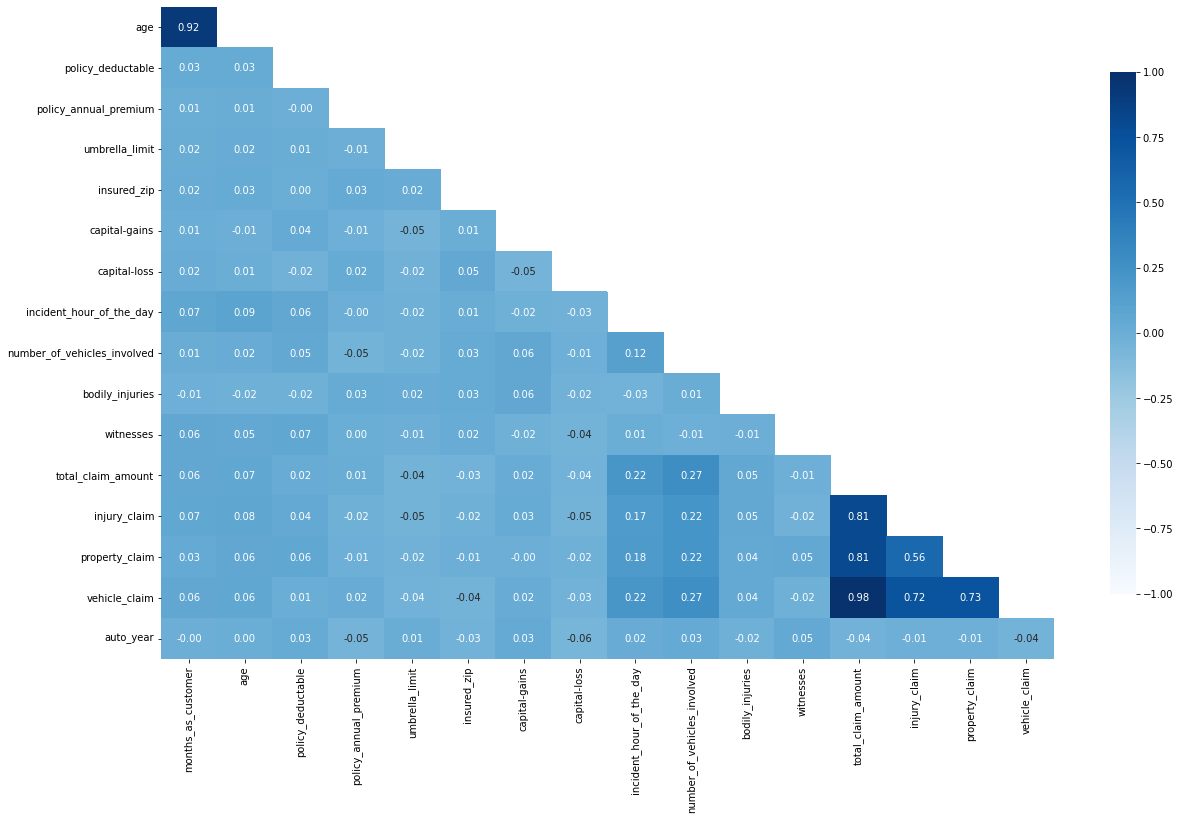

In [ ]:
##Check the correlation
# plotting correlation heatmap
import seaborn as sns

# get correlations
df_const_corr = df_const.corr()

fig, ax = plt.subplots(figsize=(20, 12))
# mask
mask = np.triu(np.ones_like(df_const_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_const_corr.iloc[1:,:-1].copy()
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()


From the above plot, we can see that there is high correlation between age and months_as_customer. We will drop the "Age" column. Also there is high correlation between total_claim_amount, injury_claim, property_claim, vehicle_claim as total claim is the sum of all others. Vehicle claim also correlates strongly with the other claim columns. There can be multiple reasons for dropping correlated columns from preventing possible bias to increasing the speed of the model, in this case the increase in speed is the main motivation. 

We will use a function to drop columns that are correlated beyond a certain threshold. We determined this threshold by looking at the above plot.

In [ ]:
def drop_correlated(data, thresh):
    """Drop columns that are correlated beyond a threshold"""
    pass

In [ ]:
correlation_threshold = 0.9

df_const = drop_correlated(df_const, correlation_threshold)
df_mode = drop_correlated(df_mode, correlation_threshold)

Columns to drop with correlation > 0.9: ['age', 'vehicle_claim']
Columns to drop with correlation > 0.9: ['age', 'vehicle_claim']


##4.3 Changing categorial data to numeric 


Categorical data is a common type of non-numerical data that contains label values that are not numbers such as colours, cities, gender, place etc. There are mainly three types of categorical data: Binary, Ordinal and Nominal data. 

1. Binary data: A variable that has only two values such as True/False or Yes/No.

2. Ordinal data: In ordinal encoding, each unique category value is assigned an integer value and can be ranked. An ordinal variable has a clear ordering. For example (low, medium and high).

3. Nominal data: Nominal data is called labelled or named data such as name, hair colour, sex etc with no rank. 

There are mainly three approaches to convert categorical data

1. Replacing values
2. Encoding labels
3. One-Hot encoding
4. Binary encoding
5. Backward difference encoding
6. Miscellaneous features

I am using label encoding for this dataset to convert the categorical dataset to numeric. 













As we still have the same columns for both df_const and df_mode we are only looking for the columns in one dataset.

If we had dropped different columns in each that would not be possible.

Also an important note is that these columns are only considered categorical for encoding purposes! This doesn't mean that no other columns represent categorical values, just that if there are, they have already been encoded to numerical values in some way. This may be important for other datasets and analyses.

In [ ]:
# find columns with categorial data for both dataset 
cat_cols = df_const.select_dtypes(include=['object']).columns.tolist()
cat_cols

['policy_bind_date',
 'policy_state',
 'policy_csl',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_date',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'incident_location',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'fraud_reported']

Here you will define a function that encodes columns containing categorical data using the LabelEncoder from sklearn. We do it over columns to avoid encoding columns that are already numerical in nature.

In [ ]:
def encode_categorical(df, cat_cols): 
  """Encode categorical columns with a LabelEncoder"""
  pass

In [ ]:
df_const = encode_categorical(df_const, cat_cols)
df_mode = encode_categorical(df_mode, cat_cols)

### 4.3.1 Uploading processed datasets

Before getting to balancing the datasets we will upload them to the Seclea Plaform.

- We define the metadata for the dataset - if there have been any changes since the original dataset we need to put that here, otherwise we can reuse the original metadata. In this case we have dropped some of the continuous feature columns so we will need to redefine

- We define the transformations that took place between the last state we uploaded and this dataset. This is a list of functions and arguments. See docs.seclea.com for more details of the correct formatting.

In [ ]:
# define the metadata
# NOTE even though we defined an index initially, because this dataset has been 
# augmented, the index has been dropped so now there is no specific index column.
processed_metadata = {"index": None, 
                  "outcome_name": "fraud_reported", 
                  "continuous_features": [
                                          # fill in here
                                          ]}

# here we need to define the transformations we applied to our original dataset
# to get it to this point.
# see the documentation for more details of the formatting this needs.

const_processed_transformations = [
    #fill in here
]

seclea.upload_dataset(dataset=df_const, 
                      dataset_name="Auto Insurance Fraud - Const Fill", 
                      metadata=processed_metadata, 
                      parent=df, 
                      transformations=const_processed_transformations)

Query Params:  {'project': 1, 'organization': 'Seclea', 'name': 'Auto Insurance Fraud - Const Fill', 'metadata': '{"index": null, "outcome_name": "fraud_reported", "continuous_features": ["total_claim_amount", "policy_annual_premium", "capital-gains", "capital-loss", "injury_claim", "property_claim", "incident_hour_of_the_day"]}', 'hash': '322653544595789370', 'parent': '1686480620896445606'}


- We need to do this for the dataset that filled NaN values with the mode. We can reuse the metadata for the processed data as it is the same but we need to change the transformations.

In [ ]:
mode_processed_transformations = [
    # fill in here
]

seclea.upload_dataset(dataset=df_mode, 
                      dataset_name="Auto Insurance Fraud - Mode Fill", 
                      metadata=processed_metadata, 
                      parent=df, 
                      transformations=mode_processed_transformations)

Query Params:  {'project': 1, 'organization': 'Seclea', 'name': 'Auto Insurance Fraud - Mode Fill', 'metadata': '{"index": null, "outcome_name": "fraud_reported", "continuous_features": ["total_claim_amount", "policy_annual_premium", "capital-gains", "capital-loss", "injury_claim", "property_claim", "incident_hour_of_the_day"]}', 'hash': '1888157424819567945', 'parent': '1686480620896445606'}


##4.4 Balancing the dataset

Most machine learning models perform best with balanced datasets and tolerate imbalanced datasets to different levels. Imbalance very often causes poor predictions, especially for minority class samples.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


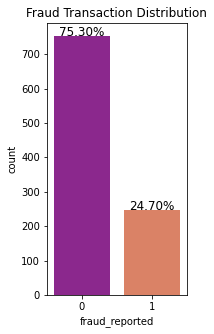

In [ ]:
#Checking for imbalance dataset (with half of the dataset)
import matplotlib.pyplot as plt
plt.figure(figsize=(2.5,5)) 
plt.title("Fraud Transaction Distribution") 
p1 = sns.countplot(df_const['fraud_reported'], palette = 'plasma') 
for p in p1.patches:
    height = p.get_height()
    p1.text(p.get_x()+p.get_width()/2.,
            height,
            f'{height/df.shape[0] * 100:.2f}%',
            ha='center', fontsize=12)

 In this dataset we are dealing with a mildly imbalanced dataset however many fraud datasets can have fraud cases making up as little as 0.1% of samples and security datasets even fewer.

We would expect to achieve fairly good accuracy on the basis of this, however we will explore the impact that balance can have on the accuracy of a model and see if balancing can be beneficial to us. 



There are more than 10 techniques available for balancing datasets. Out of all I have detailed the three most used tchniques

1.   Random under sampling: Removing majority of the class and keeping the data same as minor class. The main drawback of this technique is it may remove the important information from the dataset  

2.   Random oversampling techniques: adding more value to minority class when there is not enough data for minority class however this can cause overfitting and poor generalization. 

3. SMOTE (Synthetic Minority Oversampling Techniques ) the main idea of this techniuqe is it randomly picks a point from minority class and compute k-nearest neighbour for the point. Synthetic points are added between. 

In this dataset we will use SMOTE for balancing as random over sampling is prone to overfitting and undersampling will remove some information that may be useful to our model.



The following function has some particular restrictions in order to work well with the Seclea Platform. We need the function that processes the dataset to return the dataset in a complete form - that is with both features and labels as part of the same DataFrame. 

This will likely be changed in the future but for now you will need to split the data in the function into features and labels for the oversampling and then concat them back together after sampling to return all together from the function.

To use SMOTE you will need to import imblearn - look up the documentation for more information.

In [ ]:
# define a balancing function

def smote_balance(df):
    """Carry out SMOTE balancing over the data"""
   pass


In [ ]:
# Using Smote to balance the dataset 
df_const_smote = smote_balance(df_const)
df_mode_smote = smote_balance(df_mode)

Shape of X before SMOTE: (1000, 35)
    Shape of X after SMOTE: (1506, 35)
Shape of y before SMOTE: (1000,)
    Shape of y after SMOTE: (1506,)
Shape of X before SMOTE: (1000, 35)
    Shape of X after SMOTE: (1506, 35)
Shape of y before SMOTE: (1000,)
    Shape of y after SMOTE: (1506,)


In [ ]:
df_const_smote.head(4)

,months_as_customer,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,940,2,1,1000,1406.91,0,466132,1,4,2,17,0,53300,0,24,2,3,0,4,4,1,996,5,1,2,1,2,2,71610,6510,13020,10,1,2004,1
1,228,635,1,1,2000,1197.22,5000000,468176,1,4,6,15,2,0,0,20,3,0,1,4,5,5,628,8,1,0,0,0,0,5070,780,780,8,12,2007,1
2,134,413,2,0,2000,1413.14,5000000,430632,0,6,11,2,3,35100,0,52,0,2,1,4,1,1,685,7,3,1,2,3,1,34650,7700,3850,4,30,2007,0
3,256,19,0,1,2000,1415.74,6000000,608117,0,6,1,2,4,48900,-62400,9,2,1,0,4,2,0,669,5,1,0,1,2,1,63400,6340,6340,3,34,2014,1


In [ ]:
df_mode_smote.head(4)

,months_as_customer,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,940,2,1,1000,1406.91,0,466132,1,4,2,17,0,53300,0,24,2,2,0,4,4,1,996,5,1,1,1,2,1,71610,6510,13020,10,1,2004,1
1,228,635,1,1,2000,1197.22,5000000,468176,1,4,6,15,2,0,0,20,3,1,1,4,5,5,628,8,1,0,0,0,0,5070,780,780,8,12,2007,1
2,134,413,2,0,2000,1413.14,5000000,430632,0,6,11,2,3,35100,0,52,0,1,1,4,1,1,685,7,3,0,2,3,0,34650,7700,3850,4,30,2007,0
3,256,19,0,1,2000,1415.74,6000000,608117,0,6,1,2,4,48900,-62400,9,2,0,0,4,2,0,669,5,1,0,1,2,0,63400,6340,6340,3,34,2014,1


### 4.4.1 Upload Smote datasets

Here again we need to upload the transformed datasets.
It is easier here because we only have the one transformation to upload and the metadata we can reuse as this transformation didn't affect that.

This is in many ways the easiest way to keep track of your datasets and transformations as it saves keeping track of too many functions or variables at any one time.

Note that we include the processed datasets as the parent here, not the original dataset. That is because this dataset comes directly from the processed dataset with one transformation, not directly from the original data.

In [ ]:
# here we need to define the transformations we applied to our dataset

# Define the transformations and then upload the datasets.


Query Params:  {'project': 1, 'organization': 'Seclea', 'name': 'Auto Insurance Fraud - Const fill - Smote', 'metadata': '{"index": null, "outcome_name": "fraud_reported", "continuous_features": ["total_claim_amount", "policy_annual_premium", "capital-gains", "capital-loss", "injury_claim", "property_claim", "incident_hour_of_the_day"]}', 'hash': '-951460804795172897', 'parent': '322653544595789370'}
Query Params:  {'project': 1, 'organization': 'Seclea', 'name': 'Auto Insurance Fraud - Mode Fill - Smote', 'metadata': '{"index": null, "outcome_name": "fraud_reported", "continuous_features": ["total_claim_amount", "policy_annual_premium", "capital-gains", "capital-loss", "injury_claim", "property_claim", "incident_hour_of_the_day"]}', 'hash': '-1411472365711401547', 'parent': '1888157424819567945'}


Now head to platform.seclea.com again to take another look at the Datasets section. You will see that there is a lot more to look at this time.

You can see here how the transformations are used to show you the history of the data and how it arrived in its final state.

## 4.6 Train and Test Datasets

Now that we have finished processing our data, and logged it in the Platform, we will define a function to split the data for input to our training and evaluation code.

In [ ]:
# Splitting the dataset 

def get_test_train_splits(df, output_col, test_size, random_state):
    from sklearn.model_selection import train_test_split

    X = df.drop(output_col, axis=1)
    y = df[output_col]

    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state) 


# 5. Modeling with Balancing Techniques

Now we get started with the modelling. We will run the same models over each of our datasets to explore how the different processing of the data has affected our results.

We will use three models from sklearn for this, DecisionTree, RandomForest and GradientBoosting Classifers. 

In [ ]:
!pip install tabulate
from tabulate import tabulate


Here we are defining our classifiers in a dictionary, this will help to simplify training code later on.

In [ ]:
 ### Modeling 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

classifiers = {
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
}

Here we are training all of our classifiers on each of the datasets in turn so that we can easily and rapidly evaluate their performance.

Note the use of functions really simplifies our lives here, we do not have to repeat code here as in reality we are doing the same thing for each classifier and dataset so better to loop over each and save ourselves some typing!

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from seclea_utils.get_model_manager import Frameworks

datasets = [("Const Fill", df_const), ("Mode Fill", df_mode), ("Const Fill Smote", df_const_smote), ("Mode Fill Smote", df_mode_smote)]

for name, dataset in datasets:
    X_train, X_test, y_train, y_test = get_test_train_splits(dataset, output_col="fraud_reported", test_size=0.2, random_state=42)

    for key, classifier in classifiers.items():
        # cross validate to get an idea of generalisation.
        training_score = cross_val_score(classifier, X_train, y_train, cv=5)
        # train on the full training set
        classifier.fit(X_train, y_train)
        # upload the fully trained model
        seclea.upload_training_run(classifier, Frameworks.SKLEARN, dataset=dataset)
        # test accuracy
        y_preds = classifier.predict(X_test)
        test_score = accuracy_score(y_test, y_preds)
        print(f"Classifier: {classifier.__class__.__name__} has a Train score of {round(training_score.mean(), 3) * 100}% accuracy and Test score of {round(test_score, 3) * 100}% accuracy on {name}")

Classifier: RandomForestClassifier has a training score of 77.3% accuracy score on Const Fill
Classifier: RandomForestClassifier has a test score of 79.0% accuracy score on Const Fill
Classifier: DecisionTreeClassifier has a training score of 80.60000000000001% accuracy score on Const Fill
Classifier: DecisionTreeClassifier has a test score of 80.0% accuracy score on Const Fill
Classifier: GradientBoostingClassifier has a training score of 83.6% accuracy score on Const Fill
Classifier: GradientBoostingClassifier has a test score of 81.5% accuracy score on Const Fill
Classifier: RandomForestClassifier has a training score of 77.4% accuracy score on Mode Fill
Classifier: RandomForestClassifier has a test score of 75.5% accuracy score on Mode Fill
Classifier: DecisionTreeClassifier has a training score of 79.9% accuracy score on Mode Fill
Classifier: DecisionTreeClassifier has a test score of 79.0% accuracy score on Mode Fill
Classifier: GradientBoostingClassifier has a training score of 

So now we can see the overall results but here is a perfect opportunity to head to the Platform to dig deeper into our results and the performance differences.

## 5.1 Platform analysis

- Under the Develop tab, select Explain.
- Here you will find a list of Models - you will notice that they correspond to the three different classes of models we chose.
- Click on one of the arrows on the left of the name - a list of Training Runs expands. Here we can look at each of the models that we trained, across each of the datasets.
- Select one of them and go to the Detail Screen, where you will see a variety of important aspects of the trained model.
  - High level metrics accuracy, recall and precision.
  - A confusion matrix - this illustsrates these metrics
  - Global explanations - model feature importance and permutation feature importance. These indicate the features (columns) that are most influential on the models decision across the whole dataset.
  - Hyper-parameters - these help us to understand how the hyper-parameters affect the model quality.
- In the detail screen, you can select another training run for evaluation - do this now and see the differences in performance, hyper-parameters and feature importances.

# 6. Hyperparameter tuning


The reason for doing hyperparameter tuning is to find an optimal combination of hyperparameters that minimizes a predefined loss function to give better results. In simple words, hyper-parameters are tuned to get the best fit. I have used two types of parameters in this tutorial. One with default parameters and one by searching optimal parameters. 

In the case of the decision tree I have used default parameters whereas, in the case of random forest and Gradient boosting classifiers, I have used searching optional parameters. Using the scikit-learn best _estimator_attribute, we can then retrieve the set of hyperparameters that performed best during training to test our model.

However, in this tutorial, I haven't run the gradient boost classifier as it took me more than half an hour. This tutorial will be available for the students so you can test anytime.

DecisionTree Classifier Cross Validation Score 82.8%


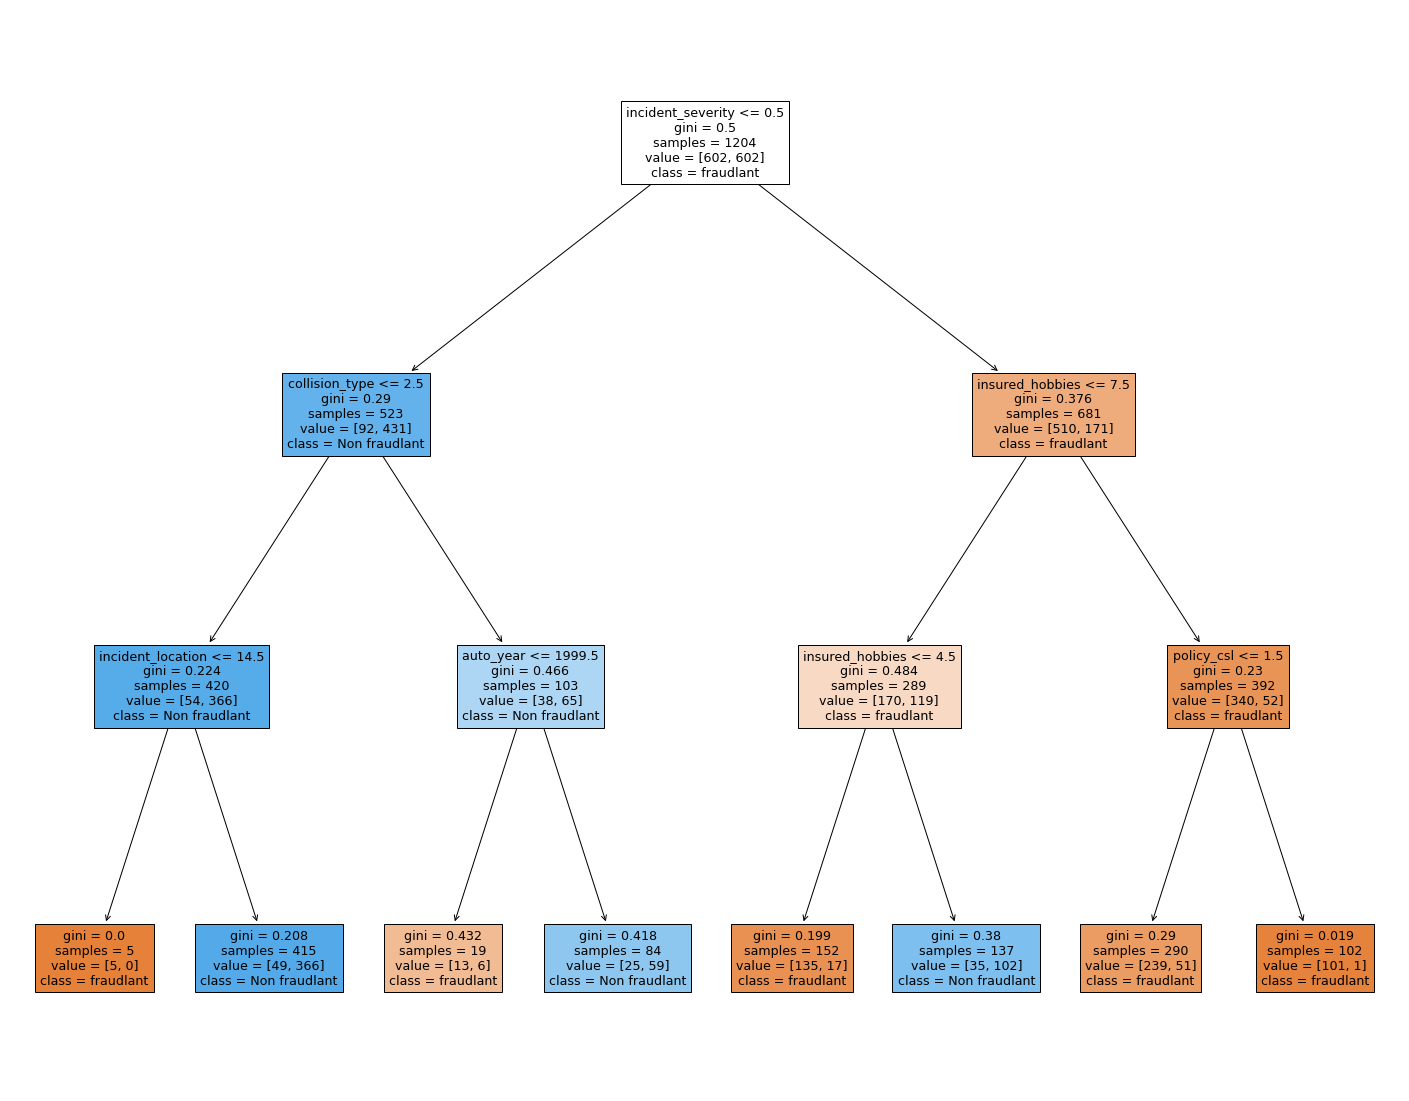

In [ ]:
# Using default hyperparameter tunning for decesion Tree  and visualize  with max depth=3 
from sklearn.model_selection import GridSearchCV

tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_sm_train, y_sm_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_
tree_score = cross_val_score(tree_clf, X_sm_train, y_sm_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_clf ,
                   feature_names=X_sm.columns,
                   class_names=['Fraudulant', "Non fraudulant"],
                   filled=True)

In [ ]:
# Hyperparameter Tuning with RandomForest Classifier
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [ ]:
## Importing Random Forest Classifier from the sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
base_estimator = RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = base_estimator, param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
rf_random.fit(X_sm_train, y_sm_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 50}

In [ ]:
print ('Random grid: ', random_grid, '\n')
#print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}  



In [ ]:
##Check the Accuracy for RandomForest  : 
print(f'Train_Accuracy-:{rf_random.score(X_sm_train, y_sm_train):.5f}')

Train_Accuracy-:1.00000


In [ ]:
## Hyperparameter Tunning with GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV

In [ ]:
# Hyperparameter Tunning with GradientBoostingClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# gbc = GradientBoostingClassifier()
# parameters = {
#    "n_estimators":[5,50,250,500],
#    "max_depth":[1,3,5,7,9],
#    "learning_rate":[0.01,0.1,1,10,100]
# }

In [ ]:
# from sklearn.model_selection import GridSearchCV
# model = GridSearchCV(gbc,parameters,cv=5)
# model.fit(X_sm_train, y_sm_train.values.ravel())

In [ ]:
# def display(results):
#    print(f'Best parameters are: {results.best_params_}')
#    print("\n")
#    mean_score = results.cv_results_['mean_test_score']
#    std_score = results.cv_results_['std_test_score']
#    params = results.cv_results_['params']
#    for mean,std,params in zip(mean_score,std_score,params):
#       print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
# display(cv)

In [ ]:
##Check the Accuracy for GradientBoostingClassifier  : 
# print(f'Train_Accuracy for GradientBoostingClassifier-:{model.score(X_sm_train, y_sm_train):.5f}')

In [ ]:
##Predicting the test set
# y_pred =  model.predict(X_test)

# 7. Evaluation of the models

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the true positive rate against the false positive rate for different decision thresholds.

The Area Under the Curve (AUC) is a measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

This metric is now more widely used than accuracy for assessing the quality of a model as it more clearly distinguishes between failure modes that are easily hidden by the accuracy rate alone.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

DecisionTree_preds = cross_val_predict(tree_clf, X_sm_train, y_sm_train, cv=5)
RandomForest_preds= cross_val_predict(base_estimator, X_sm_train, y_sm_train, cv=5)
# GradientBoosting_preds = cross_val_predict(model , X_sm_train, y_sm_train, cv=5)                             


In [ ]:
from sklearn.metrics import roc_auc_score
print('DecisionTree_Classifier: ', roc_auc_score(y_sm_train, DecisionTree_preds))
print('RandomForest_Classifier: ', roc_auc_score(y_sm_train, RandomForest_preds))
# print('GradientBoostingClassifier: ', roc_auc_score(y_sm_train, GradientBoosting_preds))

DecisionTree_Classifier:  0.8280730897009967
RandomForest_Classifier:  0.8671096345514949


In [ ]:
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_sm_train, DecisionTree_preds)
base_estimator_fpr, base_estimator_tpr, base_estimator_threshold = roc_curve(y_sm_train, RandomForest_preds)
# model_fpr, model_tpr, model_threshold = roc_curve(y_sm_train, GradientBoosting_preds)

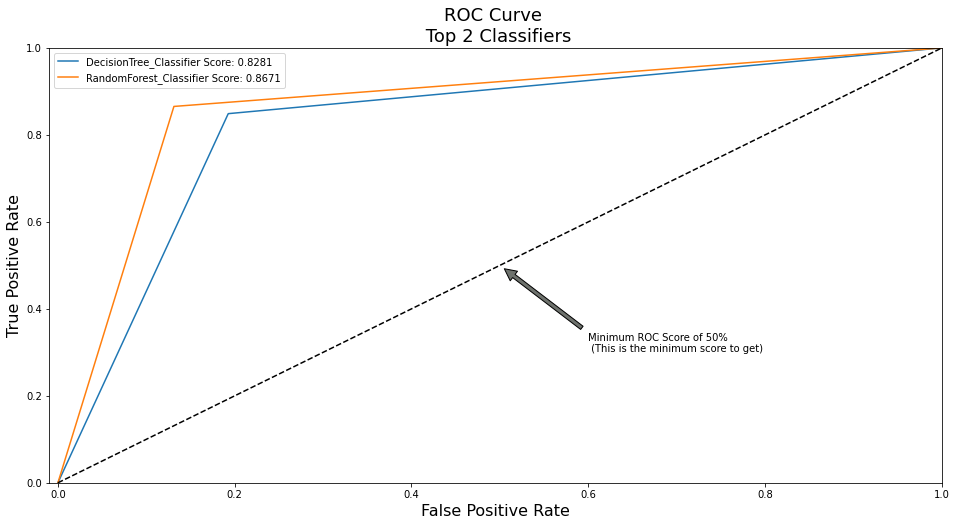

In [ ]:
def graph_roc_curve_multiple(tree_fpr, tree_tpr, base_estimator_fpr, base_estimator_tpr): #,model_fpr, model_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 2 Classifiers', fontsize=18)
    plt.plot(tree_fpr, tree_tpr, label='DecisionTree_Classifier Score: {:.4f}'.format(roc_auc_score(y_sm_train, DecisionTree_Classifier)))
    plt.plot(base_estimator_fpr, base_estimator_tpr, label='RandomForest_Classifier Score: {:.4f}'.format(roc_auc_score(y_sm_train, RandomForest_Classifier)))
    # plt.plot(model_fpr, model_tpr, label='GradientBoostingClassifier Score: {:.4f}'.format(roc_auc_score(y_sm_train, GradientBoostingClassifier)))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(tree_fpr, tree_tpr, base_estimator_fpr, base_estimator_tpr) ##,model_fpr, model_tpr)
plt.show()

From the plot, the AUC for the Random Forest Classifier ROC curve is higher than that for the Decision tree classifier ROC curve. Therefore, we can say that the Random Forest Classifier was better - which is as we would expect.